<a href="https://colab.research.google.com/github/thallescotta/fotonica-computacional-uff-2025-2/blob/main/diagrama_dispersao_TE_FDM_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- Imagem alinhada à esquerda -->
<p align="left">
  <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSHYOnIACPcb9bCeQQ_wbfF9mp5ADlbCIoghtDM6YiLklaBrtEsAxZ-G-y6N3_PNR_tCmw&usqp=CAU"
       alt="Logo CEFET"
       width="360">   <!-- tamanho da logo -->
</p>

# **Thalles Cotta Fontainha**  -  **PPGIO Matrícula: 2410091DIOAMA**

## *"Fotonica Analise Modal e BPM V2.pdf"* recebido em 11/09/2025  
### **Disciplina**: Fotônica Computacional  
**Código da disciplina:** TCE11209 – [UFF]  
**Professor:** Andres Pablo Lopez Barbero

### Bloco 1: Pré-processamento

**Objetivo:** montar a malha 1D, construir `n(x)` e resolver o problema modal TE em $ \lambda_0 $:  
$ M \cdot E = (n_\mathrm{eff}^2)\,E $.

**Entradas (µm):** `n1`, `n2`, `n3`, `w_core (d)`, `lambda0`, `dx`, `margin`.

**Saídas:** `neff_guided` (TE0, TE1, …), `modes_guided` (Nx×Nm, normalizados), `n_profile`, `x`, `T`, `D_n2`.

**Notas:** contorno Dirichlet ($E=0$ nas bordas); verificar se a margem é suficiente (campo pequeno nas bordas); unidades em µm.

## Atividade 1 — Análise Modal (Guia Planar 1D, modos TE)

**Objetivo.**  
Formular a equação de onda e resolver numericamente (diferenças finitas) o problema modal:

$$
\frac{d^2 E}{dx^2} + k_0^2\,n(x)^2\,E = \beta^2\,E
\quad\Longleftrightarrow\quad
\left[\frac{1}{k_0^2}\frac{d^2}{dx^2} + n(x)^2\right] E = n_{\mathrm{eff}}^2 E,\;\;
\beta = k_0 n_{\mathrm{eff}}.
$$

**Pipeline.**  
1. **Pré-processamento** – eu defino n(x), λ₀, a janela e a malha Δx.  
2. **Processamento** – eu monto a matriz tridiagonal do operador d²/dx² e resolvo o autoproblema  M E = n_eff² E.  
3. **Pós-processamento** – eu filtro os modos guiados n_clad < n_eff < n_core,
   normalizo e ploto E_m(x) e n(x).

[1ª Parte]: Modos guiados: 2
      TE_0: n_eff = 3.585903
      TE_1: n_eff = 3.553309


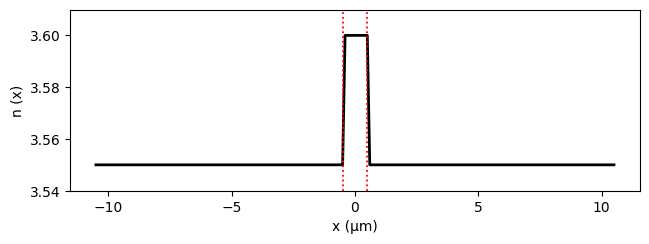

In [6]:
# ==============================================================================
# Bloco 1: Pré-processamento + FDM (Finite Difference Method) + Perfil n(x)
# ==============================================================================
import numpy as np                     # importa biblioteca numérica
import matplotlib.pyplot as plt        # importa biblioteca para gráficos

um = 1.0                                # define unidade de comprimento (µm)
n1, n2, n3 = 3.55, 3.60, 3.55           # índices de refração das três camadas
w_core, lambda0 = 1.0*um, 1.0*um        # largura do núcleo e comprimento de onda
dx, margin = 0.10*um, 10.0*um           # passo da malha e margem da janela

Lx = w_core + 2*margin                  # comprimento total da janela de simulação
x  = np.arange(-Lx/2, Lx/2 + dx/2, dx)  # vetor de posições na direção x
Nx = x.size                             # número total de pontos da malha

n_profile = np.full(Nx, n1)             # inicia perfil de índice com valor n1
core_mask = (np.abs(x) <= w_core/2)     # identifica pontos dentro do núcleo
n_profile[core_mask] = n2               # define n2 no núcleo
right_mask = (x > w_core/2)             # identifica pontos à direita do núcleo
n_profile[right_mask] = n3              # define n3 no revestimento direito

k0 = 2*np.pi/lambda0                    # calcula número de onda no vácuo
Nint = Nx - 2                           # número de pontos internos (exclui bordas)
main = -2.0*np.ones(Nint)               # diagonal principal da matriz Laplaciana
off  =  1.0*np.ones(Nint-1)             # diagonais secundárias da matriz Laplaciana
T = np.diag(main, 0) + np.diag(off, 1) + np.diag(off, -1)  # matriz tridiagonal da 2ª derivada

n_int = n_profile[1:-1]                 # extrai perfil de índice para pontos internos
D_n2  = np.diag(n_int**2)               # matriz diagonal com n(x)^2
M = (T/(k0**2 * dx**2)) + D_n2          # matriz do problema de autovalores

eigvals, eigvecs = np.linalg.eigh(M)    # resolve autovalores e autovetores
order = np.argsort(eigvals)[::-1]       # ordena autovalores em ordem decrescente
neff2 = eigvals[order]                  # autovalores ordenados
modes_int = eigvecs[:, order]           # autovetores correspondentes

neff = np.sqrt(np.clip(neff2, 0, None)) # calcula índices efetivos n_eff
guided_mask = (neff < n2 - 1e-12) & (neff > n1 + 1e-12)  # seleciona modos guiados
neff_guided = neff[guided_mask]         # extrai n_eff dos modos guiados
modes_guided_int = modes_int[:, guided_mask]            # extrai modos internos guiados

def pad_mode(Eint):                     # insere bordas com valor zero
    E = np.zeros(Nx)                     # cria vetor com zeros
    E[1:-1] = Eint                        # coloca solução interna no centro
    return E

modes_guided = (np.stack([pad_mode(m) for m in modes_guided_int.T], axis=1)
                if modes_guided_int.size else np.empty((Nx,0)))  # recompõe modos completos
for k in range(modes_guided.shape[1]):   # normaliza cada modo guiado
    Ek = modes_guided[:, k]               # extrai modo k
    area = np.trapezoid(np.abs(Ek)**2, x) # calcula energia do campo
    if area > 0:                          # evita divisão por zero
        modes_guided[:, k] = Ek/np.sqrt(area)  # normaliza modo

print(f"[1ª Parte]: Modos guiados: {neff_guided.size}")   # imprime quantidade de modos guiados
for i, ng in enumerate(neff_guided):                     # imprime n_eff de cada modo
    print(f"      TE_{i}: n_eff = {ng:.6f}")

plt.figure(figsize=(6.6,2.6))            # cria figura para o perfil de índice
plt.plot(x, n_profile, 'k', lw=2)        # plota perfil n(x)
xb1, xb2 = -w_core/2, +w_core/2          # define bordas do núcleo
plt.axvline(xb1, color='r', ls=':', lw=1.3) # marca borda esquerda
plt.axvline(xb2, color='r', ls=':', lw=1.3) # marca borda direita
plt.xlabel("x (µm)")                     # rótulo eixo x
plt.ylabel("n (x)")                      # rótulo eixo y
plt.ylim(n1 - 0.01, n2 + 0.01)           # ajusta limites do eixo y
plt.grid(False)                          # remove grade
plt.tight_layout()                       # ajusta layout
plt.show()                                # exibe figura


### Bloco 2: Processamento dos Modos

**Objetivo:** processar e plotar os modos `TE_i` com paredes do núcleo tracejadas e um **zoom central** para destacar a região do núcleo.

**Pré-requisitos:** `x`, `w_core`, `modes_guided` (produzidos no Bloco 1).

**Parâmetros de visualização:**
- `FIG_W`, `FIG_H_PER_MODE`, `DPI`: dimensões e resolução da figura.
- `ZOOM_HALF_WIDTH`: meia-largura do recorte em torno de $x=0$ (apenas visual).
- `DASH_DASHES`: padrão de tracejado das paredes (tupla matplotlib).
- `PAINT_OUTSIDE_D`: se `True`, suaviza/“apaga” o campo fora do núcleo para ênfase.

**Saída:** subplots dos modos (limpos, sem grades/ticks), com fase alinhada no centro apenas por estética.

**Notas:** o zoom não altera os dados; apenas limita o eixo $x$.  
Se não houver modos (`modes_guided.shape[1]==0`), nada é plotado.

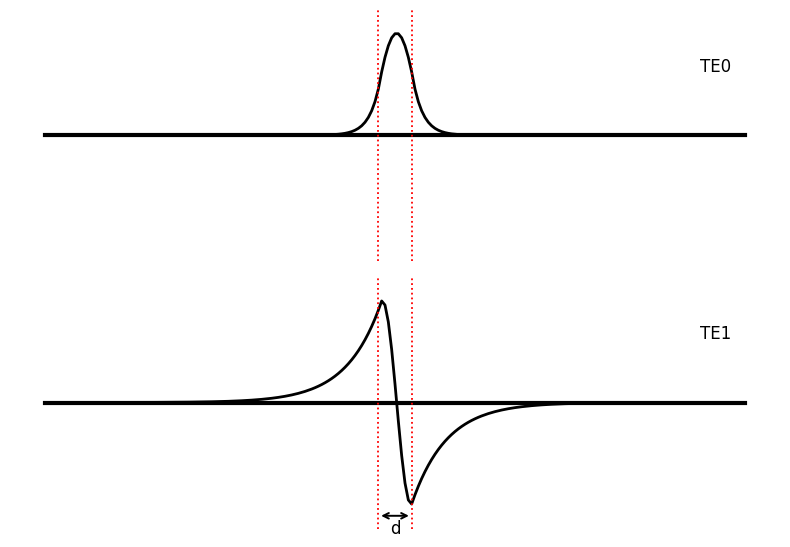

In [7]:
# ==============================================================================
# Bloco 2: Plots "estilo livro" dos modos (figura ampliada)
# ==============================================================================
N_TO_SHOW = min(4, modes_guided.shape[1])      # número máximo de modos a exibir (até 4 ou total disponível)
if N_TO_SHOW > 0:                              # só plota se houver modos guiados
    xb1, xb2 = -w_core/2, +w_core/2             # bordas do núcleo
    L = x[-1] - x[0]                            # largura total do domínio

    fig, axes = plt.subplots(N_TO_SHOW, 1, figsize=(8.0, 2.8*N_TO_SHOW), sharex=True)  # cria subplots empilhados
    if N_TO_SHOW == 1:                          # garante que axes seja lista mesmo com 1 subplot
        axes = [axes]
    for i, ax in enumerate(axes):               # percorre cada modo a ser plotado
        Ei = modes_guided[:, i].copy()          # copia o campo do modo i
        i0 = np.argmin(np.abs(x))               # índice mais próximo de x=0
        if Ei[i0] < 0:                          # ajusta sinal para valor positivo em x=0
            Ei = -Ei
        s = np.max(np.abs(Ei)) or 1.0           # máximo para normalização (evita divisão por zero)
        y = 0.95*Ei/s                           # campo normalizado e levemente escalado

        ax.plot([x[0], x[-1]], [0, 0], 'k', lw=3)  # linha de base preta
        ax.plot(x, y, 'k', lw=2)                  # curva do modo normalizado

        ax.axvline(xb1, color='r', ls=':', lw=1.3) # marca borda esquerda do núcleo
        ax.axvline(xb2, color='r', ls=':', lw=1.3) # marca borda direita do núcleo
        ax.text(x[-1]-0.02*L, 0.65, f"TE{i}", ha='right', va='center', fontsize=12)  # rótulo do modo

        ax.set_ylim(-1.18, 1.18)                 # define limites verticais
        ax.set_yticks([]); ax.set_xticks([])     # remove marcações dos eixos
        for sp in ('left','right','top','bottom'):
            ax.spines[sp].set_visible(False)     # remove bordas do gráfico

    ax_bot = axes[-1]                            # eixo do último subplot
    ax_bot.annotate('', xy=(xb1, -1.06), xytext=(xb2, -1.06),
                    arrowprops=dict(arrowstyle='<->', color='k', lw=1.4))  # seta de largura do núcleo
    ax_bot.text((xb1+xb2)/2, -1.09, 'd', ha='center', va='top', fontsize=12)  # rótulo "d" no meio

    plt.tight_layout()                           # ajusta espaçamento da figura
    plt.show()                                    # exibe a figura final
else:
    print("[2ª Parte]: Nenhum modo guiado encontrado para o plot")  # mensagem se não houver modos


### Bloco 3: Pós-processamento (Diagrama de Dispersão)

**Objetivo:** traçar $n_\mathrm{eff}$ vs. $(d/\lambda)$ via FDM, separado por ordem de modo (TE0, TE1, …).

**Entradas (do Bloco 1):** `T`, `D_n2`, `dx`, `w_core`, `n1`, `n2`.

**Parâmetros:** `MAX_MODES`, `D_lambda_grid` (ex.: 0→5 com ~1001/1002 pts; evitar 0 usando p.ex. `1e-6`).

**Saídas:** figura do diagrama; dicionário `curves[m]` (m=0…); validação impressa em `d/λ = 1.0` (opcional).

**Critério de guia:** filtra modos com $n_1 < n_\mathrm{eff} < n_2$; ordenação **decrescente** por $n_\mathrm{eff}$ (TE0 no topo).

**Recursos visuais:** linhas verticais pontilhadas por amostra; linhas extras em inteiros; grade horizontal no eixo Y; eixo direito com $\theta$ usando $n_\mathrm{eff}=n_2\sin\theta$ (**assume $n_\text{core}=n_2$**; sem o tick de 90°); linhas horizontais em $n_1$ e $n_2$.

**Notas:** custo cresce com o nº de amostras (`numpy.linalg.eigh` ≈ $O(N^3)$ por $\lambda$); garanta `margin` suficiente no Bloco 1 para campo pequeno nas bordas; implementação sem SciPy.


--- BLOCO 3: PÓS-PROCESSAMENTO (Diagrama de Dispersão) ---


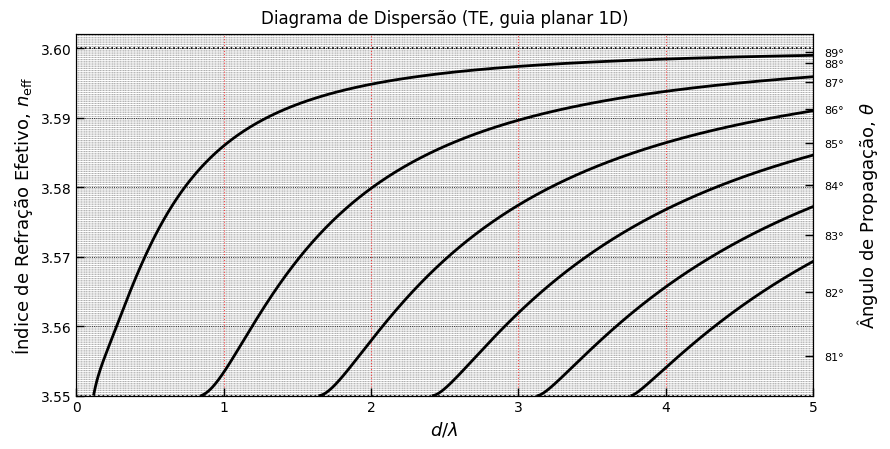


--- VALIDAÇÃO (d/λ = 1.0) ---
  Modo TE0: n_eff = 3.585886
  Modo TE1: n_eff = 3.553278


In [8]:
# ==============================================================================
# ETAPA 3: PÓS-PROCESSAMENTO (Com Diagrama de Dispersão)
# ==============================================================================
print("\n--- BLOCO 3: PÓS-PROCESSAMENTO (Diagrama de Dispersão) ---")  # cabeçalho informativo

# Sweep em d/λ
MAX_MODES = 6                                                     # máximo de ordens de modos a registrar
D_lambda_grid = np.linspace(0.0, 5.0, 1002)                      # grade de d/λ no eixo x
D_lambda_grid[0] = 1e-6                                          # evita divisão por zero em λ
lambda_grid = w_core / D_lambda_grid                             # converte d/λ para λ correspondente

# Curvas por ordem de modo
curves = {m: np.full_like(D_lambda_grid, np.nan, dtype=float)    # pré-aloca vetor de n_eff para cada modo
          for m in range(MAX_MODES)}

# Loop em λ (FDM)
for j, lambda0_sweep in enumerate(lambda_grid):                  # varre cada λ da grade
    k0 = 2*np.pi / lambda0_sweep                                  # número de onda para λ atual
    M_sweep = (T/(k0**2 * dx**2)) + D_n2                          # matriz do problema para este λ
    lam, _ = np.linalg.eigh(M_sweep)                              # autovalores (n_eff^2) e autovetores
    neff_all = np.sqrt(np.clip(lam, 0.0, None))                   # converte para n_eff (≥0)
    neff_all = neff_all[(neff_all > n1 + 1e-12) & (neff_all < n2 - 1e-12)]  # filtra modos guiados
    neff_all = np.sort(neff_all)[::-1]                            # ordena do mais alto para o mais baixo
    for m in range(min(MAX_MODES, neff_all.size)):                # registra até MAX_MODES curvas
        curves[m][j] = neff_all[m]                                # salva n_eff da ordem m no ponto j

# ---------- Plot ----------
plt.figure(figsize=(9, 4.6))                                     # cria figura do diagrama

# (1) linhas verticais pontilhadas em TODOS os x da grade
for xv in D_lambda_grid:                                         # linhas de referência finas
    plt.axvline(xv, color='k', ls=':', lw=0.5, alpha=0.35, zorder=0)

# (2) linhas verticais extras nos valores inteiros
for x_int in range(1, 6):                                        # destaca d/λ = 1..5
    plt.axvline(x=x_int, color='red', ls=':', lw=0.8, alpha=0.7, zorder=1)

# (3) curvas n_eff (sem marcadores)
for m in range(MAX_MODES):                                       # plota cada ordem de modo
    y = curves[m]                                                 # série n_eff(d/λ) do modo m
    mask = np.isfinite(y)                                         # pontos válidos (calculados)
    if np.any(mask):                                              # evita séries vazias
        plt.plot(D_lambda_grid[mask], y[mask], 'k', lw=2.0, zorder=2)  # curva preta contínua

# Limites/rotulagem
plt.xlim(0.0, 5.0)                                               # intervalo de d/λ no eixo x
plt.ylim(n1, n2 + 0.002)                                         # intervalo de n_eff no eixo y
plt.xlabel(r"$d/\lambda$", fontsize=13)                          # rótulo do eixo x
plt.ylabel(r"Índice de Refração Efetivo, $n_\mathrm{eff}$", fontsize=13)  # rótulo do eixo y
plt.title("Diagrama de Dispersão (TE, guia planar 1D)", fontsize=12, pad=8)  # título do gráfico

# Eixo principal + grade horizontal pontilhada
ax = plt.gca()                                                   # obtém eixo atual
ax.tick_params(axis='both', which='both', direction='in', length=6, width=1)  # estilo dos ticks
ax.set_yticks(np.arange(n1, n2 + 0.0001, 0.01))                  # ticks de n_eff a cada 0,01
ax.grid(axis='y', which='major', color='k', linestyle=':', linewidth=0.6)     # grade horizontal

# Eixo direito: θ (n_eff = n_core * sen θ), removendo apenas 90°
ax2 = ax.twinx()                                                 # cria eixo y secundário
theta_deg = np.arange(80, 90.1, 1.0)                             # ticks de 80° a 90°
theta_rad = np.deg2rad(theta_deg)                                # converte para radianos
neff_ticks = n2 * np.sin(theta_rad)                              # mapeia θ → n_eff (assumindo n_core = n2)
mask_all = (neff_ticks >= n1) & (neff_ticks <= n2)               # restringe à faixa do gráfico
mask_no90 = mask_all & (theta_deg < 90)                          # remove exatamente 90°
ax2.set_ylim(ax.get_ylim())                                      # sincroniza limites verticais
ax2.set_yticks(neff_ticks[mask_no90])                            # posiciona ticks do eixo direito
ax2.set_yticklabels([f"{t:.0f}°" for t in theta_deg[mask_no90]], fontsize=8)  # rótulos em graus
ax2.set_ylabel(r"Ângulo de Propagação, $\theta$", fontsize=13, labelpad=8)    # rótulo do eixo direito
ax2.tick_params(axis='y', which='both', direction='in', length=6, width=1, pad=8)  # estilo dos ticks

# Linhas horizontais de referência em n1/n2
plt.axhline(n1, color='k', ls=':', lw=1.2, zorder=1)             # linha em n1 (substrato/cladding)
plt.axhline(n2, color='k', ls=':', lw=1.2, zorder=1)             # linha em n2 (núcleo)

plt.tight_layout()                                               # ajusta espaçamentos
plt.show()                                                       # exibe a figura

# ---------- Validação no ponto d/λ = 1.0 ----------
D_lambda_teste = 1.0                                             # ponto de validação no eixo x
idx = np.argmin(np.abs(D_lambda_grid - D_lambda_teste))          # índice mais próximo de d/λ=1
neffs_teste = [curves[m][idx] for m in range(MAX_MODES)          # coleta n_eff válidos no ponto
                if np.isfinite(curves[m][idx])]

print(f"\n--- VALIDAÇÃO (d/λ = {D_lambda_teste:.1f}) ---")        # cabeçalho da validação
if neffs_teste:                                                  # houve modos no ponto?
    for i, ne in enumerate(sorted(neffs_teste, reverse=True)):    # ordena por n_eff decrescente
        print(f"  Modo TE{i}: n_eff = {ne:.6f}")                  # imprime n_eff dos modos
else:
    print("Nenhum modo guiado encontrado no ponto de validação.") # mensagem se vazio

### Bloco 4: Referências

**Objetivo:** registrar as principais referências bibliográficas, de código e o repositório GitHub utilizado neste trabalho.

**Referências:**
- **OKAMOTO, Katsunari.** *Fundamentals of Optical Waveguides*. Elsevier, 2021.  
  [PDF no meu GitHub](https://github.com/thallescotta/fotonica-computacional-uff-2025-2/blob/main/%5BKatsunari_Okamoto%5D_Fundamentals_of_optical_waveguide.pdf)
- **modesolverpy.** Photonic mode solver em Python (SciPy/Matplotlib) com exemplos práticos de solução modal.  
  [Repositório GitHub de Documentação](https://github.com/jtambasco/modesolverpy)

- **Repositório deste Projeto:**  
[https://github.com/thallescotta/fotonica-computacional-uff-2025-2](https://github.com/thallescotta/fotonica-computacional-uff-2025-2)

## *Linguagens utilizadas:*

[![Python](https://img.shields.io/badge/Python-3.11%2B-blue?logo=python&logoColor=white)](https://www.python.org/)
[![Jupyter](https://img.shields.io/badge/Jupyter-Notebook-orange?logo=jupyter&logoColor=white)](https://jupyter.org/)
[![NumPy](https://img.shields.io/badge/NumPy-1.x-lightgrey?logo=numpy&logoColor=013243)](https://numpy.org/)
[![Matplotlib](https://img.shields.io/badge/Matplotlib-3.x-lightgrey?logo=plotly&logoColor=white)](https://matplotlib.org/)
